<a href="https://colab.research.google.com/github/Afra17/BootCamp_Sdaia_DL_W4/blob/main/Project_Wee4_SDAIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import torch
import os
import json
from PIL import Image
from torchvision import transforms
from datasets import load_dataset
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

In [20]:
class_names = [
    "Uhud-Martyrs-Square",
    "Uhud-mounten",
    "Ghars-Well",
    "Quba-Mosque",
    "The-Prophet's-Mosque",
    "Urwah-Ibn-Az-Zubayr-Palace"
]
label2id = {name: i for i, name in enumerate(class_names)}
id2label = {i: name for i, name in enumerate(class_names)}


In [21]:
print(label2id)

{'Uhud-Martyrs-Square': 0, 'Uhud-mounten': 1, 'Ghars-Well': 2, 'Quba-Mosque': 3, "The-Prophet's-Mosque": 4, 'Urwah-Ibn-Az-Zubayr-Palace': 5}


In [22]:
image_dir = "/content/images"

dataset = load_dataset("imagefolder", data_dir=image_dir, split="train")


Resolving data files:   0%|          | 0/94 [00:00<?, ?it/s]

In [23]:
print(dataset.column_names)

['image']


In [26]:
def add_labels(example):
    path = example['image'].filename if hasattr(example['image'], 'filename') else ""
    example['labels'] = 0
    for i, name in enumerate(class_names):
        if name in path:
            example['labels'] = i
            break
    return example

dataset = dataset.map(add_labels)

Map:   0%|          | 0/94 [00:00<?, ? examples/s]

In [27]:
main_split = dataset.train_test_split(test_size=0.3, seed=42)

large_raw_data = main_split["train"]
small_raw_data = main_split["test"]

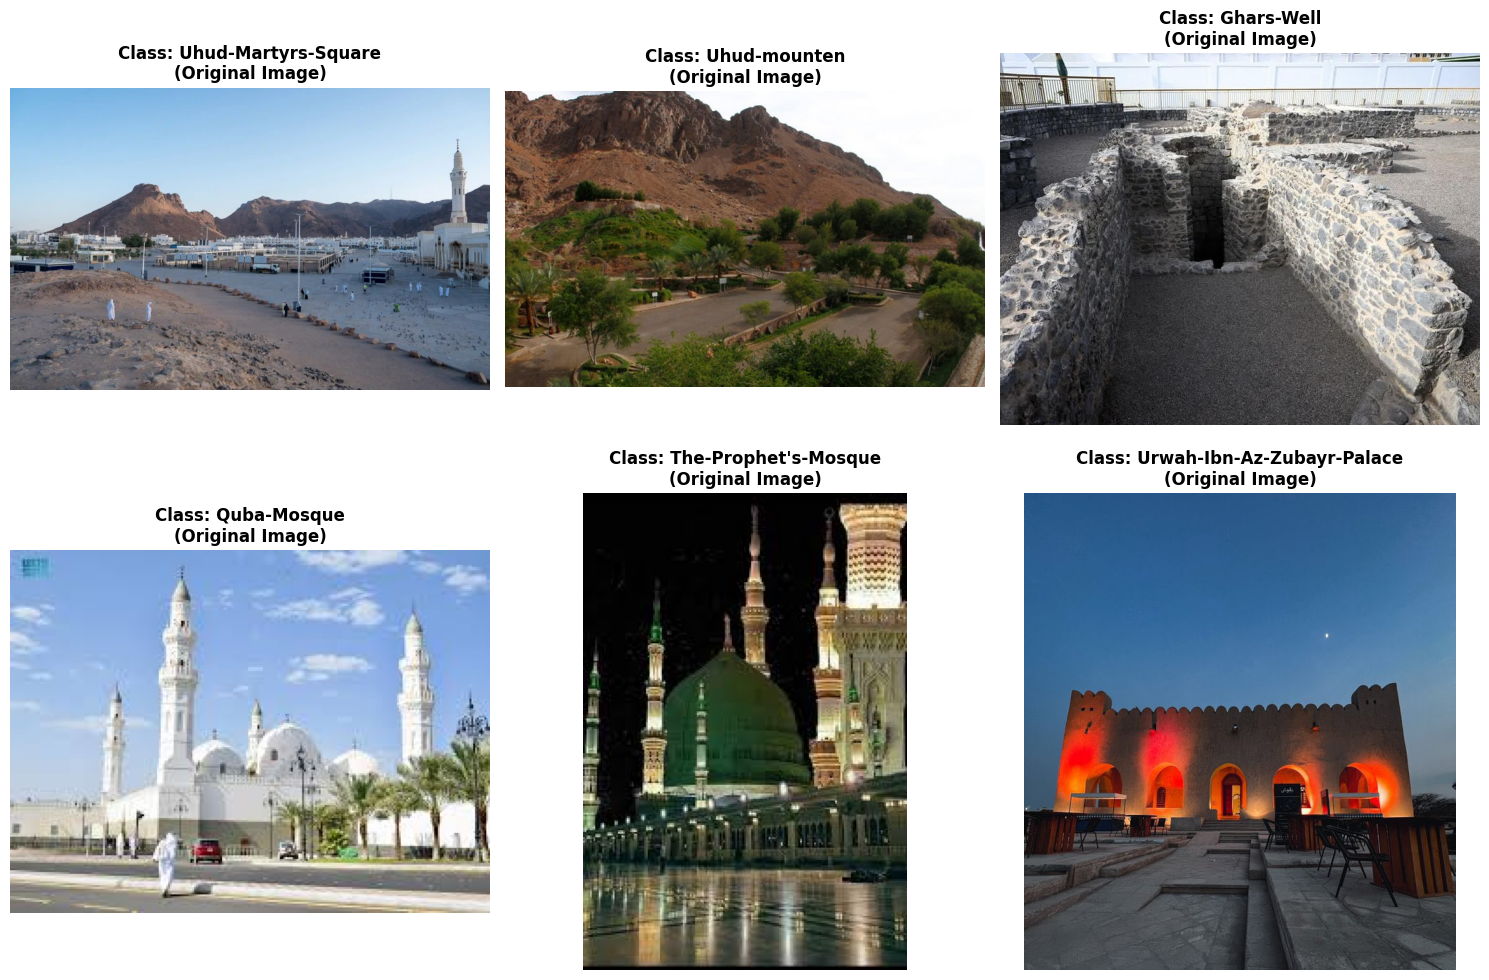

In [29]:
import matplotlib.pyplot as plt

unique_labels = sorted(list(set(main_split["train"]["labels"])))
num_classes = len(unique_labels)

cols = 3
rows = (num_classes // cols) + (1 if num_classes % cols != 0 else 0)
plt.figure(figsize=(15, rows * 5))

for i, label_id in enumerate(unique_labels):
    idx = main_split["train"]["labels"].index(label_id)
    raw_sample = main_split["train"][idx]
    img = raw_sample["image"]
    class_name = id2label[label_id]
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {class_name}\n(Original Image)", fontsize=12, fontweight='bold')
    plt.axis("off")

plt.tight_layout()
plt.show()

In [30]:
large_splits = large_raw_data.train_test_split(test_size=0.2, seed=42)
large_train_raw = large_splits["train"]
large_test_raw  = large_splits["test"]

small_splits = small_raw_data.train_test_split(test_size=0.2, seed=42)
small_train_raw = small_splits["train"]
small_test_raw  = small_splits["test"]

In [31]:
augmentation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [32]:

def transform_fn(examples):
    # 1. Process images into pixel_values
    examples["pixel_values"] = [
        augmentation_transforms(img.convert("RGB")) for img in examples["image"]
    ]

    # 2. Map label to labels
    examples["labels"] = examples["labels"]

    # 3. CRITICAL: Remove the raw image objects so the collator doesn't see them
    # This prevents the "Could not infer dtype" error
    del examples["image"]

    return examples

large_train = large_train_raw.with_transform(transform_fn)
large_test  = large_test_raw.with_transform(transform_fn)

small_train = small_train_raw.with_transform(transform_fn)
small_test  = small_test_raw.with_transform(transform_fn)


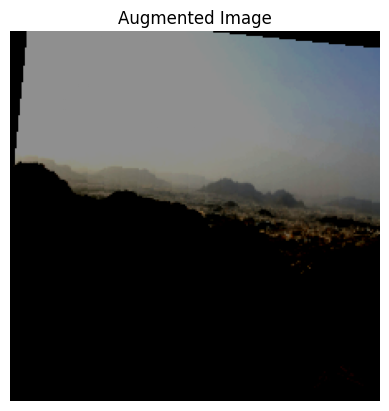

In [33]:
import matplotlib.pyplot as plt

# 1. Grab one example (the transform runs NOW)
example = large_train[30]

# 2. Get the augmented pixel values
# Note: If your transform outputs a Tensor, we transpose from (C, H, W) to (H, W, C)
image_data = example["pixel_values"]

# 3. Display it
plt.imshow(image_data.permute(1, 2, 0) if hasattr(image_data, 'permute') else image_data)
plt.title("Augmented Image")
plt.axis("off")
plt.show()

# model

In [34]:
model_id = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_id)

model = ViTForImageClassification.from_pretrained(
    model_id,
    num_labels=len(class_names),
    id2label=id2label,
    label2id=label2id
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# full fine-tuning

In [44]:
import os
os.environ["WANDB_DISABLED"] = "true"
training_args = TrainingArguments(
    output_dir="./vit-full-finetune",
    per_device_train_batch_size=8,
    learning_rate=2e-5,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    remove_unused_columns=False,   # Keep this False
    logging_steps=1,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=large_train,
    eval_dataset=large_test
)

In [45]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.151200,1.533100
2,1.046100,1.447412
3,1.055700,1.396942
4,1.025000,1.369790
5,1.006700,1.328245
6,1.114800,1.322156
7,0.761700,1.254014
8,0.802000,1.297760
9,0.695400,1.269790
10,0.922700,1.238501


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument i

TrainOutput(global_step=70, training_loss=0.960607647895813, metrics={'train_runtime': 1532.8934, 'train_samples_per_second': 0.339, 'train_steps_per_second': 0.046, 'total_flos': 4.02972792348672e+16, 'train_loss': 0.960607647895813, 'epoch': 10.0})

In [46]:
trainer.save_model("./my_best_model")
processor.save_pretrained("./my_best_model")

['./my_best_model/preprocessor_config.json']

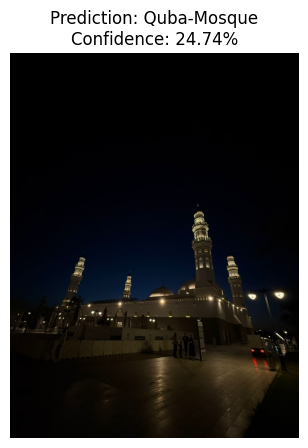

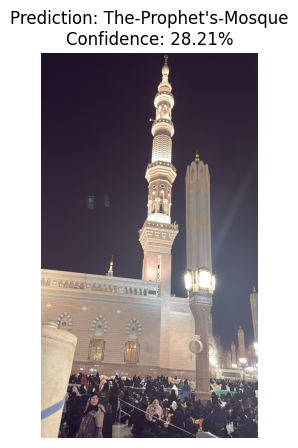

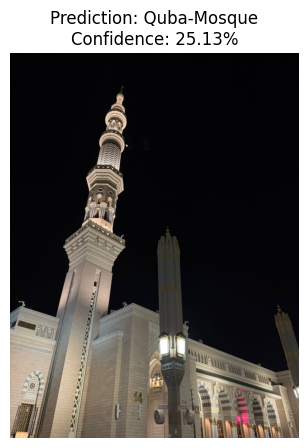

In [52]:
import os
from PIL import Image
import torch

new_data_path = "/content/test_data"

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def test_new_data(folder_path):
    images = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    if not images:
        print("there is't any images")
        return

    for img_name in images:
        full_path = os.path.join(folder_path, img_name)
        img = Image.open(full_path).convert("RGB")

        inputs = processor(images=img, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)

            conf, pred_idx = torch.max(probs, dim=-1)
            predicted_label = id2label[pred_idx.item()]
            confidence_score = conf.item() * 100

        plt.figure(figsize=(8, 5))
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence_score:.2f}%")
        plt.axis("off")
        plt.show()

test_new_data(new_data_path)

# LORA


In [53]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    modules_to_save=["classifier"]
)

model2= get_peft_model(model, lora_config)
device = "cuda" if torch.cuda.is_available() else "cpu"
model2.to(device)
model2.print_trainable_parameters()

trainable params: 594,438 || all params: 86,397,708 || trainable%: 0.6880


In [54]:
training_args = TrainingArguments(
    output_dir="./medina-vit-lora-final",
    remove_unused_columns=False,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    learning_rate=1e-3,
    num_train_epochs=50,
    logging_steps=5,
    save_strategy="epoch",
    fp16=True if device == "cuda" else False,
    report_to="none"
)

In [55]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

trainer = Trainer(
    model=model2,
    args=training_args,
    train_dataset=large_train,
    eval_dataset=large_test
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
5,0.738800
10,0.672600
15,0.523800
20,0.430100
25,0.384400
30,0.255600
35,0.187100
40,0.202000
45,0.103100
50,0.123300


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument i

TrainOutput(global_step=650, training_loss=0.03593790018214629, metrics={'train_runtime': 4013.8303, 'train_samples_per_second': 0.648, 'train_steps_per_second': 0.162, 'total_flos': 2.028822773612544e+17, 'train_loss': 0.03593790018214629, 'epoch': 50.0})

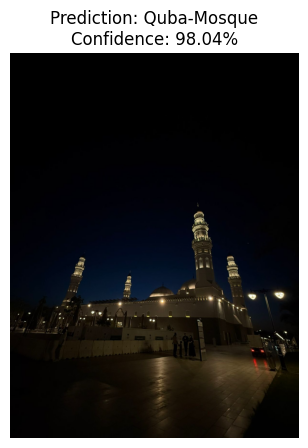

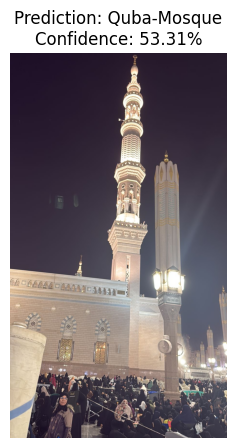

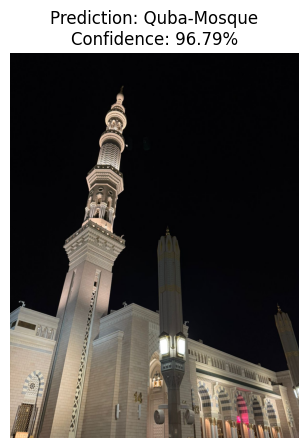

In [56]:
import os
from PIL import Image
import torch

new_data_path = "/content/test_data"

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def test_new_data(folder_path):
    images = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    if not images:
        print("there is't any images")
        return

    for img_name in images:
        full_path = os.path.join(folder_path, img_name)
        img = Image.open(full_path).convert("RGB")

        inputs = processor(images=img, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model2(**inputs)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)

            conf, pred_idx = torch.max(probs, dim=-1)
            predicted_label = id2label[pred_idx.item()]
            confidence_score = conf.item() * 100

        plt.figure(figsize=(8, 5))
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence_score:.2f}%")
        plt.axis("off")
        plt.show()

test_new_data(new_data_path)